**Dataset & dataloaders**

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw






  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw






  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw






  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




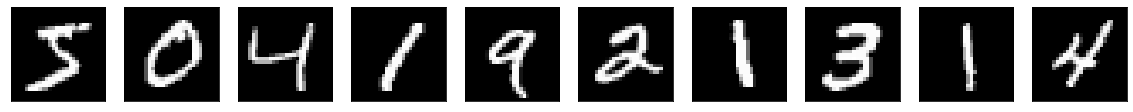

In [1]:
# Import the required libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

transform = transforms.Compose([transforms.ToTensor()])

batch_size = 256 # batch size

# Download and load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a data loader to load the dataset in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)


# Import the required libraries for plotting
import matplotlib.pyplot as plt
import numpy as np

num_pictures = 10					# Plot the first 10 images from the dataset
plt.figure(figsize=(20,5))	# Create a new figure. The figsize parameter is used to set the size of the figure in inches, in this case (20,5). 
for i in range(num_pictures):
	img = trainset[i][0]
	ax = plt.subplot(1,num_pictures,i+1)
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)  
	plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
plt.show()

**Model architecture**

In [2]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_dim= 28*28  # Input image dimension
hidden_dim=400    # hiden layer dimension
code_dim=20       # Latent dimension

# Simple VAE architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        #encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)       # 784 , 400
        self.fc21 = nn.Linear(hidden_dim, code_dim)       # 400 , 20
        self.fc22 = nn.Linear(hidden_dim, code_dim)       # 400 , 20

        #decoder
        self.fc3 = nn.Linear(code_dim, hidden_dim)        #  20 , 400
        self.fc4 = nn.Linear(hidden_dim, input_dim)       # 400 , 784

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)   # Obtain standard deviation from logvar
        eps = torch.randn_like(std)   # Random variable epsilon. "torch.randn_like" is a PyTorch function that returns a tensor with the same shape and size as 
                                      # the input tensor, filled with random values generated from a normal distribution with mean 0 and standard deviation 1.
        return mu + eps*std           # Return the latent variable

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784)) # Obtain mu and logvar from the encoder. This line of code is calling the 'encode' method on the input data 'x'
                                                  # which has been reshaped to a 2D tensor of size (-1, 784). 
        z = self.reparameterize(mu, logvar)       # Calculate te latent variable z
        recon = self.decode(z)                    # recon is the reconstructed image from the decoder
        return recon, mu, logvar


model = VAE().to(device)  # Create an instance of the VAE (Variational Autoencoder) model, and assign it to the variable 'model'.
                          # The 'to(device)' function is used to move the model to a specified device like GPU if available,
                          # it is used to perform computations on the model using the specified device.

print(model)              # Show the model architecture

VAE(

  (fc1): Linear(in_features=784, out_features=400, bias=True)

  (fc21): Linear(in_features=400, out_features=20, bias=True)

  (fc22): Linear(in_features=400, out_features=20, bias=True)

  (fc3): Linear(in_features=20, out_features=400, bias=True)

  (fc4): Linear(in_features=400, out_features=784, bias=True)

)


**Optimizer and loss function**

In [ ]:
# Import the torch.optim module, which contains various optimization algorithms, and assigns it to the variable "optim".
# This allows the user to call various optimization functions such as Adam, SGD, etc from the optim module using the "optim" variable.
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # Creates an Adam optimizer object and assigns it to the variable "optimizer".

def criterion(recon_x, x, mu, logvar):  # loss function for VAE models. Refer to the slides
  RTE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum') # Recontruction term. 
  KLD = - 0.5 * torch.sum( 1 + logvar - mu**2 - logvar.exp() )            # Kullback–Leibler divergence
  return RTE + KLD

**Sampling**

In [ ]:
no_images = 5       # Number of images to generate
images_size = 28    # Dimension of the images
images_channels = 1 # Number of channels of the image (grayscale in this case)

# Sampling function
def sampling():
  with torch.no_grad():                     # do not track gradients while generating images
    noise = torch.randn(64, 20).to(device)  # generate a tensor of random values with shape (64, 20) and move it to device
    sample = model.decode(noise).cpu()      # pass the tensor through the model's decode method and move it to CPU
    fig = plt.figure(figsize=(10,10))       # create a figure with size (10,10)
    for i in range(no_images):              # loop through number of images
      plt.subplot(1, no_images, i+1)        # add a subplot to the figure
      plt.imshow(sample[i].reshape(28,28),cmap='gray')  # display the image in the subplot
      plt.axis('off')                       # turn off the axis
      
  plt.show()  # show the figure

**Training**

Training Started


epoch: 1 of 100, loss: 0.48418: : 235it [00:07, 30.83it/s]                       


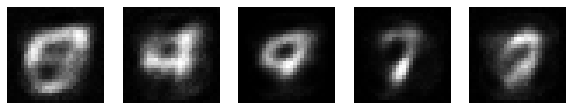

epoch: 2 of 100, loss: 0.33953: : 235it [00:14, 16.10it/s]                       


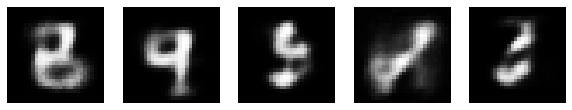

epoch: 3 of 100, loss: 0.30797: : 235it [00:07, 33.16it/s]


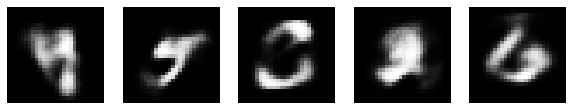

epoch: 4 of 100, loss: 0.29515: : 235it [00:07, 32.50it/s]                       


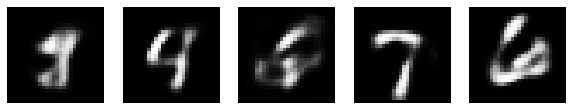

epoch: 5 of 100, loss: 0.28815: : 235it [00:07, 32.95it/s]                       


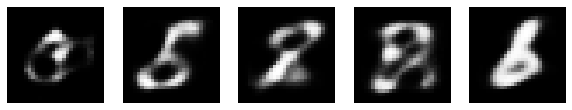

epoch: 6 of 100, loss: 0.28390: : 235it [00:07, 33.05it/s]


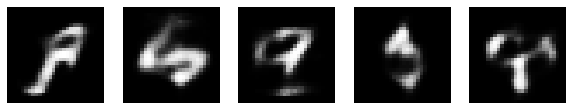

epoch: 7 of 100, loss: 0.28072: : 235it [00:07, 32.98it/s]                       


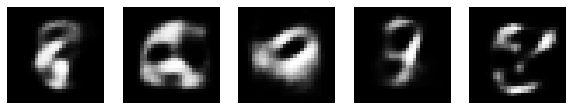

epoch: 8 of 100, loss: 0.27824: : 235it [00:07, 33.23it/s]                       


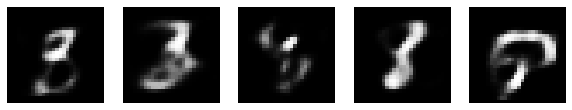

epoch: 9 of 100, loss: 0.27635: : 235it [00:07, 33.10it/s]                       


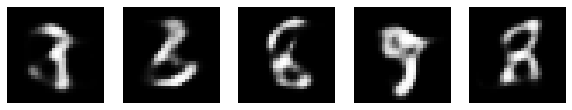

epoch: 10 of 100, loss: 0.27476: : 235it [00:07, 32.79it/s]                       


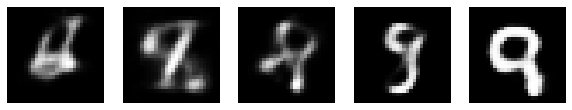

epoch: 11 of 100, loss: 0.27362: : 235it [00:07, 32.66it/s]                       


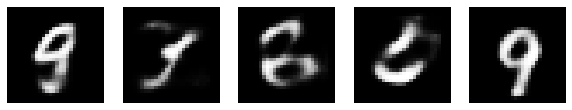

epoch: 12 of 100, loss: 0.27243: : 235it [00:08, 28.15it/s]                       


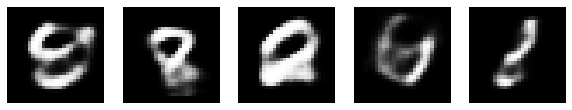

epoch: 13 of 100, loss: 0.27148: : 235it [00:07, 32.48it/s]                       


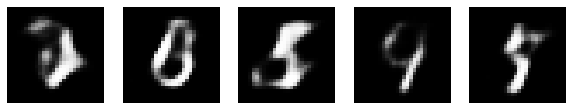

epoch: 14 of 100, loss: 0.27084: : 235it [00:07, 32.74it/s]                       


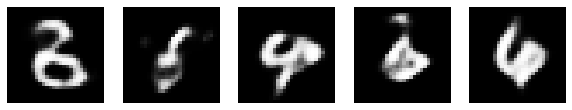

epoch: 15 of 100, loss: 0.26989: : 235it [00:08, 28.99it/s]                       


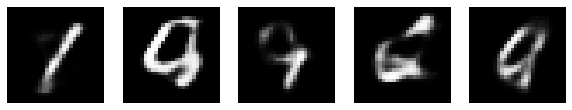

epoch: 16 of 100, loss: 0.26944: : 235it [00:07, 32.40it/s]                       


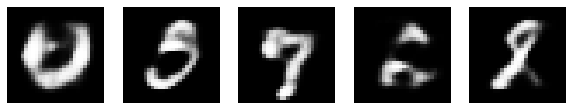

epoch: 17 of 100, loss: 0.26869: : 235it [00:07, 32.43it/s]                       


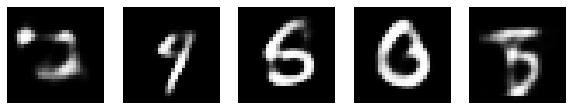

epoch: 18 of 100, loss: 0.26821: : 235it [00:07, 32.26it/s]                       


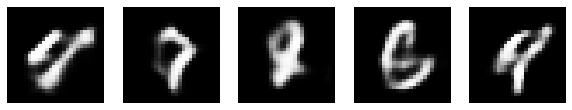

epoch: 19 of 100, loss: 0.26777: : 235it [00:07, 32.26it/s]


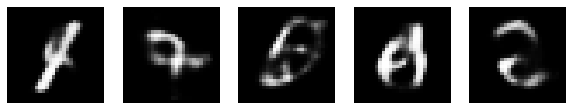

epoch: 20 of 100, loss: 0.26729: : 235it [00:07, 31.78it/s]                       


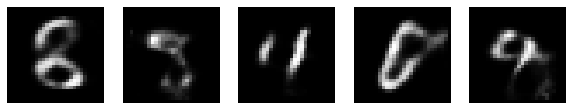

epoch: 21 of 100, loss: 0.26679: : 235it [00:07, 31.85it/s]                       


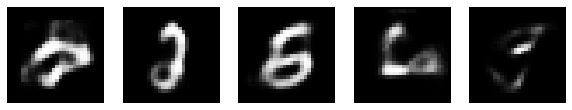

epoch: 22 of 100, loss: 0.26652: : 235it [00:07, 32.51it/s]                       


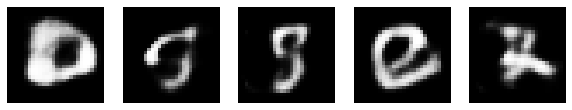

epoch: 23 of 100, loss: 0.26606: : 235it [00:07, 32.34it/s]                       


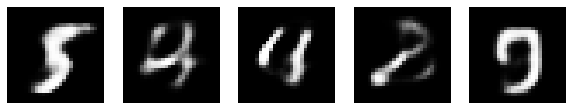

epoch: 24 of 100, loss: 0.26582: : 235it [00:07, 32.32it/s]                       


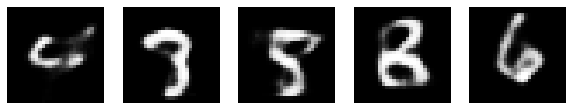

epoch: 25 of 100, loss: 0.26535: : 235it [00:07, 31.45it/s]                       


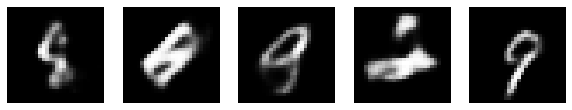

epoch: 26 of 100, loss: 0.26509: : 235it [00:07, 31.81it/s]


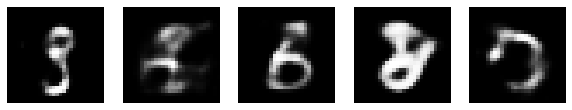

epoch: 27 of 100, loss: 0.26499: : 235it [00:07, 31.66it/s]                       


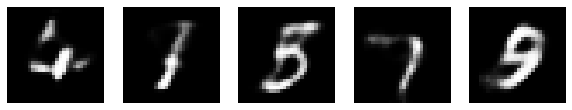

epoch: 28 of 100, loss: 0.26462: : 235it [00:07, 32.06it/s]                       


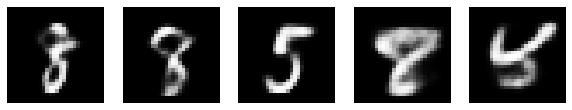

epoch: 29 of 100, loss: 0.26435: : 235it [00:07, 31.76it/s]                       


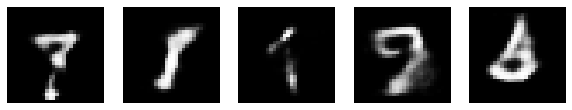

epoch: 30 of 100, loss: 0.26424: : 235it [00:07, 31.69it/s]                       


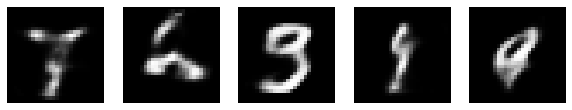

epoch: 31 of 100, loss: 0.26395: : 235it [00:07, 31.77it/s]                       


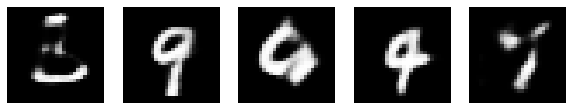

epoch: 32 of 100, loss: 0.26360: : 235it [00:07, 31.55it/s]                       


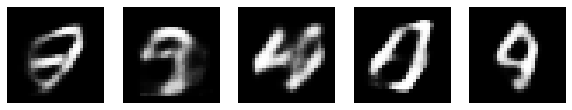

epoch: 33 of 100, loss: 0.26337: : 235it [00:07, 30.97it/s]


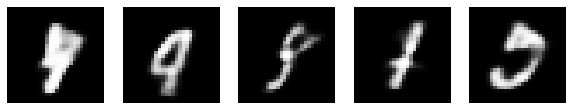

epoch: 34 of 100, loss: 0.26319: : 235it [00:07, 31.23it/s]                       


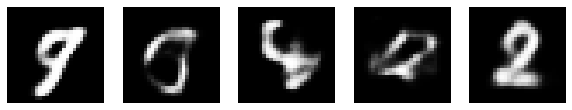

epoch: 35 of 100, loss: 0.26298: : 235it [00:07, 31.10it/s]                       


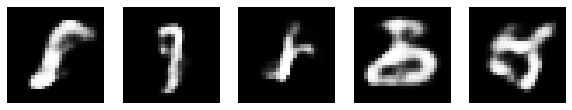

epoch: 36 of 100, loss: 0.26273: : 235it [00:07, 31.08it/s]                       


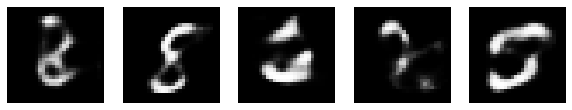

epoch: 37 of 100, loss: 0.26272: : 235it [00:07, 31.27it/s]                       


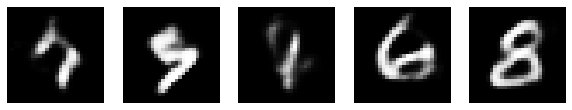

epoch: 38 of 100, loss: 0.26238: : 235it [00:07, 31.44it/s]                       


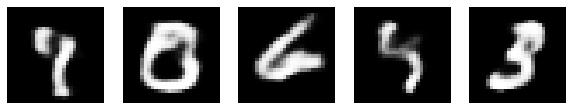

epoch: 39 of 100, loss: 0.26226: : 235it [00:07, 31.72it/s]                       


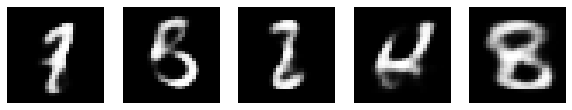

epoch: 40 of 100, loss: 0.26212: : 235it [00:07, 31.72it/s]                       


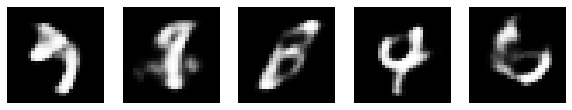

epoch: 41 of 100, loss: 0.26194: : 235it [00:08, 27.94it/s]


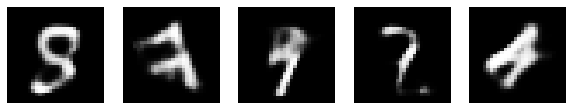

epoch: 42 of 100, loss: 0.26183: : 235it [00:07, 31.41it/s]


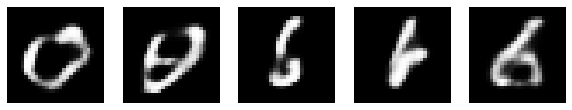

epoch: 43 of 100, loss: 0.26174: : 235it [00:07, 31.37it/s]                       


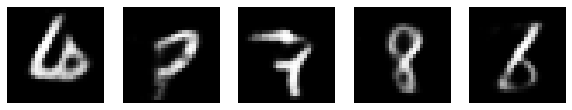

epoch: 44 of 100, loss: 0.26143: : 235it [00:07, 31.55it/s]                       


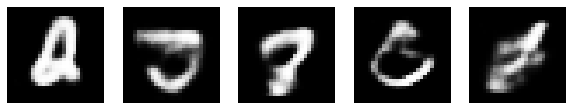

epoch: 45 of 100, loss: 0.26143: : 235it [00:07, 30.85it/s]


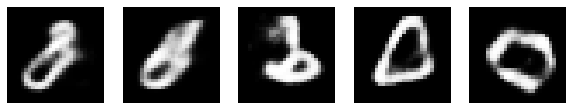

epoch: 46 of 100, loss: 0.26120: : 235it [00:07, 30.84it/s]                       


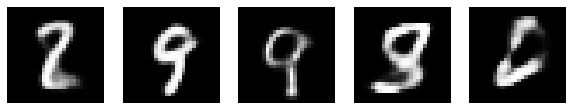

epoch: 47 of 100, loss: 0.26100: : 235it [00:07, 31.17it/s]


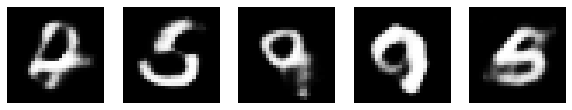

epoch: 48 of 100, loss: 0.26090: : 235it [00:07, 31.22it/s]                       


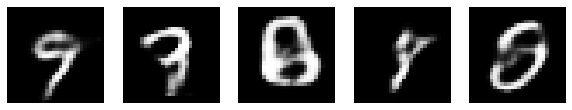

epoch: 49 of 100, loss: 0.26081: : 235it [00:07, 30.63it/s]                       


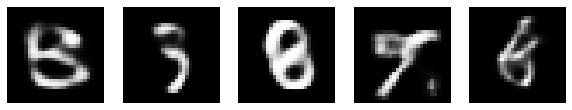

epoch: 50 of 100, loss: 0.26055: : 235it [00:07, 31.12it/s]


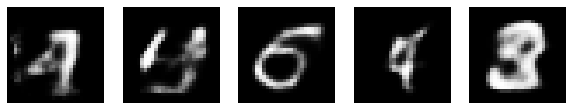

epoch: 51 of 100, loss: 0.26053: : 235it [00:07, 31.07it/s]


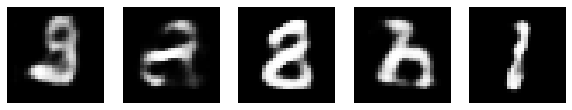

epoch: 52 of 100, loss: 0.26048: : 235it [00:07, 31.05it/s]                       


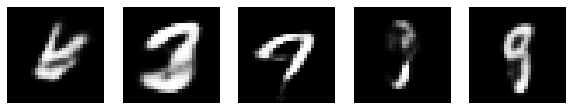

epoch: 53 of 100, loss: 0.26035: : 235it [00:07, 31.20it/s]


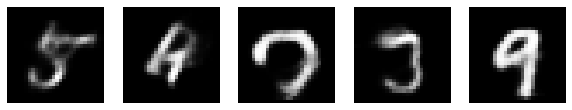

epoch: 54 of 100, loss: 0.26014: : 235it [00:07, 31.27it/s]                       


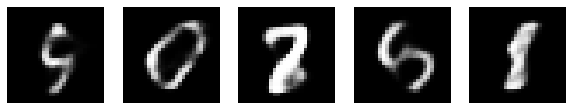

epoch: 55 of 100, loss: 0.26011: : 235it [00:07, 32.03it/s]


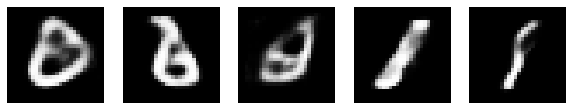

epoch: 56 of 100, loss: 0.26007: : 235it [00:07, 30.94it/s]                       


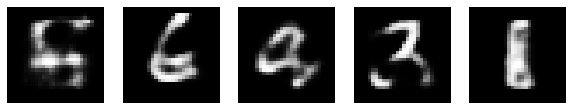

epoch: 57 of 100, loss: 0.25996: : 235it [00:07, 31.10it/s]                       


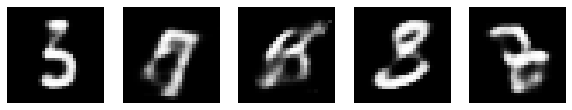

epoch: 58 of 100, loss: 0.25985: : 235it [00:07, 30.22it/s]                       


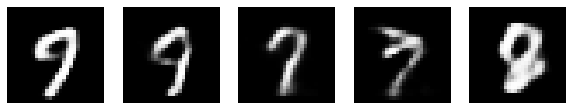

epoch: 59 of 100, loss: 0.25976: : 235it [00:07, 30.91it/s]                       


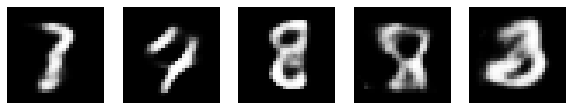

epoch: 60 of 100, loss: 0.25971: : 235it [00:07, 30.65it/s]                       


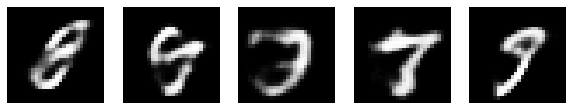

epoch: 61 of 100, loss: 0.25955: : 235it [00:07, 30.48it/s]                       


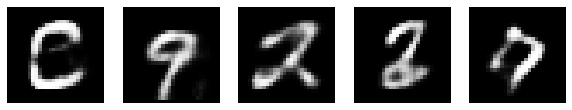

epoch: 62 of 100, loss: 0.25937: : 235it [00:07, 30.99it/s]


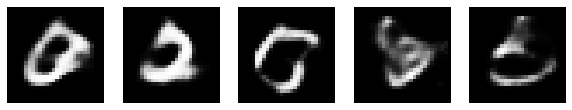

epoch: 63 of 100, loss: 0.25930: : 235it [00:07, 30.69it/s]                       


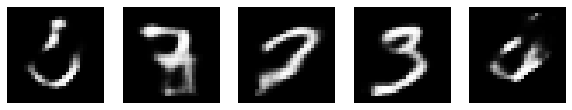

epoch: 64 of 100, loss: 0.25929: : 235it [00:07, 29.96it/s]                       


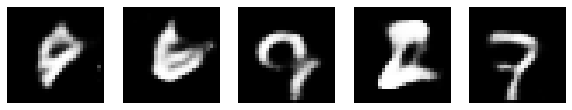

epoch: 65 of 100, loss: 0.25924: : 235it [00:07, 30.26it/s]


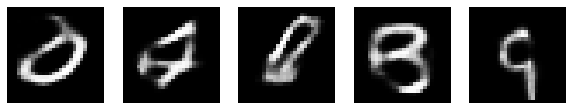

epoch: 66 of 100, loss: 0.25912: : 235it [00:08, 26.42it/s]


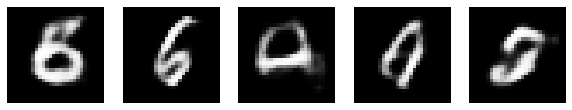

epoch: 67 of 100, loss: 0.25895: : 235it [00:07, 29.91it/s]


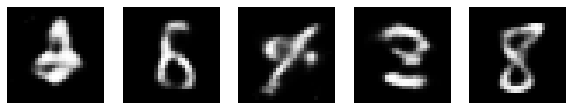

epoch: 68 of 100, loss: 0.25902: : 235it [00:07, 29.73it/s]


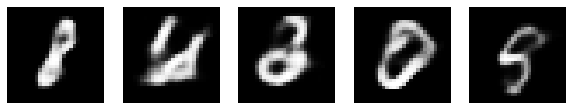

epoch: 69 of 100, loss: 0.25876: : 235it [00:07, 29.76it/s]                       


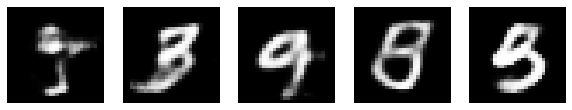

epoch: 70 of 100, loss: 0.25874: : 235it [00:07, 29.94it/s]                       


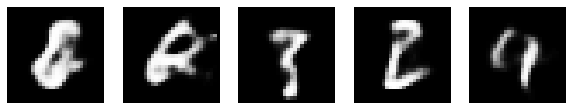

epoch: 71 of 100, loss: 0.25874: : 235it [00:07, 30.37it/s]


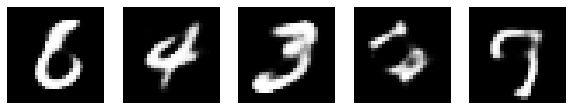

epoch: 72 of 100, loss: 0.25867: : 235it [00:07, 29.46it/s]


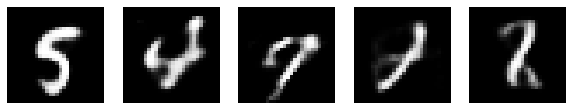

epoch: 73 of 100, loss: 0.25854: : 235it [00:07, 29.56it/s]


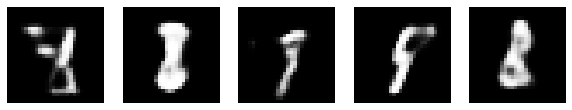

epoch: 74 of 100, loss: 0.25852: : 235it [00:08, 29.37it/s]                       


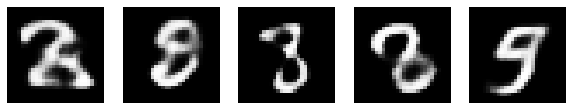

epoch: 75 of 100, loss: 0.25836: : 235it [00:07, 29.49it/s]                       


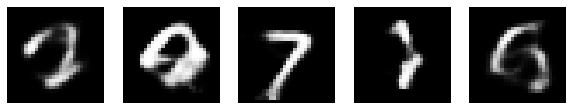

epoch: 76 of 100, loss: 0.25832: : 235it [00:07, 29.50it/s]                       


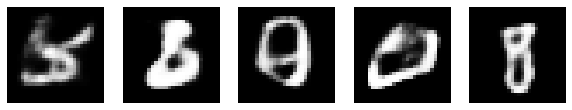

epoch: 77 of 100, loss: 0.25836: : 235it [00:07, 29.94it/s]


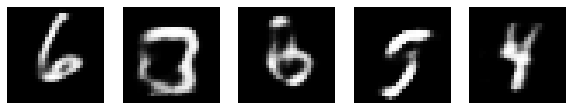

epoch: 78 of 100, loss: 0.25832: : 235it [00:07, 30.08it/s]                       


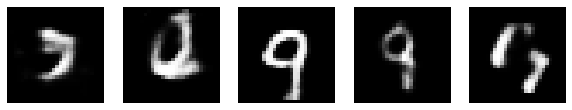

epoch: 79 of 100, loss: 0.25817: : 235it [00:07, 29.95it/s]                       


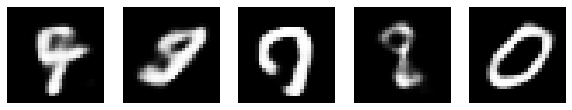

epoch: 80 of 100, loss: 0.25816: : 235it [00:07, 29.83it/s]                       


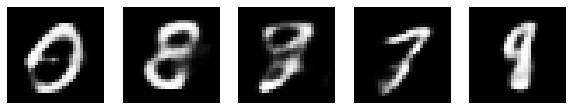

epoch: 81 of 100, loss: 0.25796: : 235it [00:07, 29.46it/s]                       


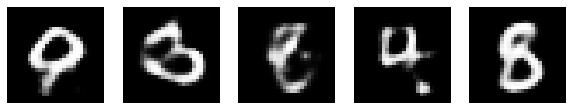

epoch: 82 of 100, loss: 0.25793: : 235it [00:08, 29.25it/s]                       


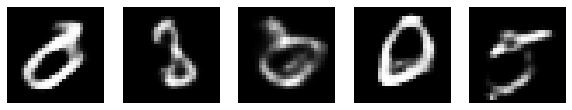

epoch: 83 of 100, loss: 0.25792: : 235it [00:07, 29.73it/s]                       


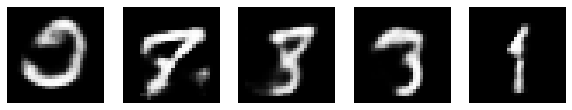

epoch: 84 of 100, loss: 0.25790: : 235it [00:07, 29.68it/s]


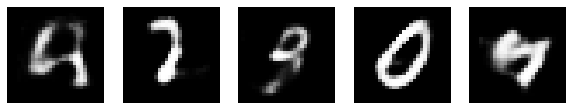

epoch: 85 of 100, loss: 0.25780: : 235it [00:08, 29.33it/s]


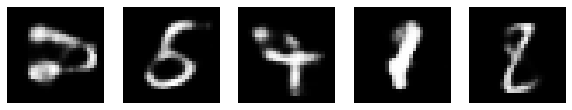

epoch: 86 of 100, loss: 0.25767: : 235it [00:08, 29.29it/s]


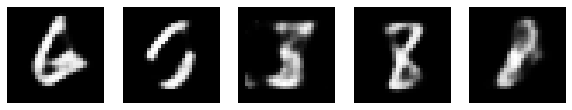

epoch: 87 of 100, loss: 0.25768: : 235it [00:08, 29.11it/s]                       


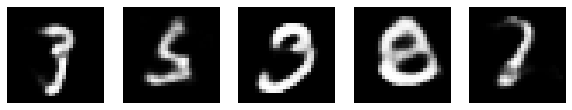

epoch: 88 of 100, loss: 0.25768: : 235it [00:08, 29.04it/s]                       


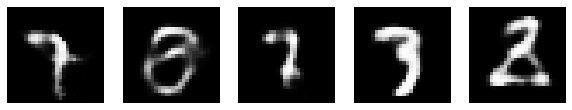

epoch: 89 of 100, loss: 0.25747: : 235it [00:08, 27.81it/s]


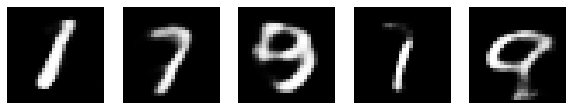

epoch: 90 of 100, loss: 0.25747: : 235it [00:08, 27.03it/s]                       


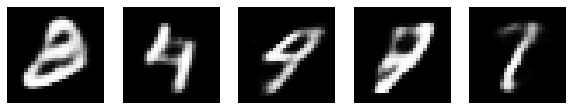

epoch: 91 of 100, loss: 0.25728: : 235it [00:08, 28.72it/s]


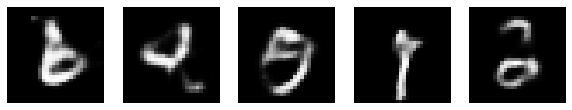

epoch: 92 of 100, loss: 0.25737: : 235it [00:08, 29.04it/s]                       


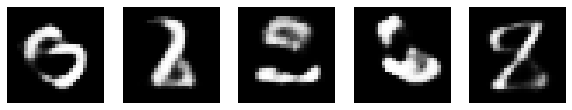

epoch: 93 of 100, loss: 0.25735: : 235it [00:07, 29.49it/s]                       


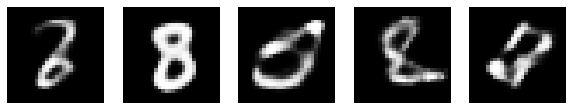

epoch: 94 of 100, loss: 0.25725: : 235it [00:08, 29.12it/s]                       


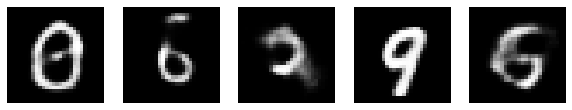

epoch: 95 of 100, loss: 0.25724: : 235it [00:08, 28.33it/s]                       


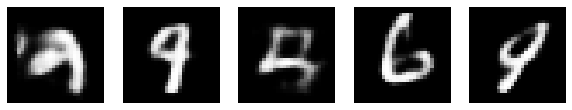

epoch: 96 of 100, loss: 0.25714: : 235it [00:08, 28.71it/s]                       


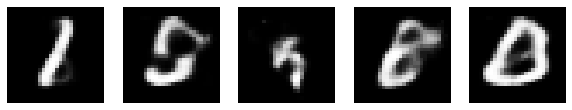

epoch: 97 of 100, loss: 0.25711: : 235it [00:08, 29.21it/s]                       


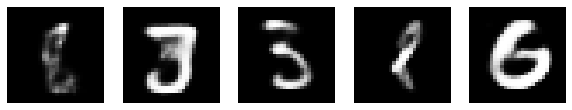

epoch: 98 of 100, loss: 0.25705: : 235it [00:08, 28.86it/s]                       


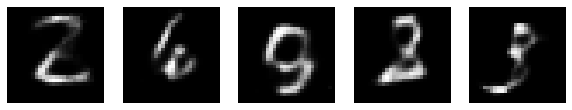

epoch: 99 of 100, loss: 0.25704: : 235it [00:08, 28.70it/s]                       


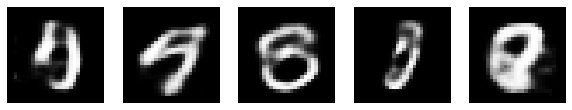

epoch: 100 of 100, loss: 0.25706: : 235it [00:08, 28.79it/s]                       


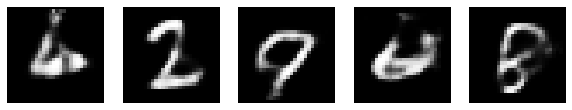

Training Finished


In [ ]:
from torch.autograd import Variable
# Import tqdm library
from tqdm import tqdm

#number of epochs for training
num_epochs = 100;

print('Training Started') # Start the training
for epoch in range(num_epochs):  # loop over the dataset multiple times
		model.train()	# Set the model's "train" mode on. In PyTorch, models have two different modes: train mode and evaluation mode.
									# When the model is in train mode, certain operations such as dropout and batch normalization behave differently than when the model
									# is in evaluation mode. This line of code is  used before the model is trained, to set it in the correct mode for training.
		running_loss = 0.0	# Set to zero the variable running_loss use to calculate the average loss during training
		pbar = tqdm(enumerate(trainloader, 0), total=int(len(trainset) / trainloader.batch_size)) # Creates a progress bar using the tqdm library.
		for i, data in pbar:
        # get the inputs; data is a list of [inputs, labels]
				inputs, _ = data

				inputs = inputs.to(device)	# Move the inputs tensor from its current location to a specific device

				# Zero the parameter gradients
				optimizer.zero_grad()	# Before the optimizer updates the parameters, the gradients need to be zeroed out so that the optimizer can calculate

				recon_batch, mu, logvar = model(inputs) # Calculation of the model's output
				loss = criterion(recon_batch, inputs, mu, logvar) # Calculation of the loss between the model's output and the target using a criterion function.
				loss.backward() 	# Computation of the gradients of the loss with respect to the model's parameters. This is done using the "backward" method on the loss tensor.
				optimizer.step()	# Updates of the model's parameters. This step will update the model's parameters in the direction that reduces the loss.
        
                # print statistics
				running_loss += loss.item() # Accumulate the loss
				pbar.set_description(f'epoch: {epoch + 1} of {num_epochs}, loss: {running_loss/(i+1)/1e5:.5f}') # print the current epoch, the total epochs
		# Show samples
		sampling()

print('Training Finished')	# Training finished

########################################################################
# Save trained model:

PATH = './savedModel.pth'
torch.save(model.state_dict(), PATH)